In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
from scipy.io import loadmat
from scipy.optimize import minimize, fmin_tnc

In [2]:
import os
for i in os.listdir():
    if '.mat' in i:
        print(i)


ex8data1.mat
ex8data2.mat
ex8_movieParams.mat
ex8_movies.mat


In [3]:
data = loadmat('ex8_movieParams.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])

In [4]:
X = data['X']
theta = data['Theta']

In [5]:
Y = loadmat('ex8_movies.mat')['Y']
R = loadmat('ex8_movies.mat')['R']

In [6]:
X.shape, theta.shape, Y.shape, R.shape

((1682, 10), (943, 10), (1682, 943), (1682, 943))

In [7]:
nm, nu = Y.shape
n = data['num_features'][0][0]

In [8]:
print('Average rating for the first movie "Toy Story" is {}/5'.format(round(np.sum(Y[0]) / np.sum(R[0]),2)))

Average rating for the first movie "Toy Story" is 3.88/5


# Visualize the ratings matrix

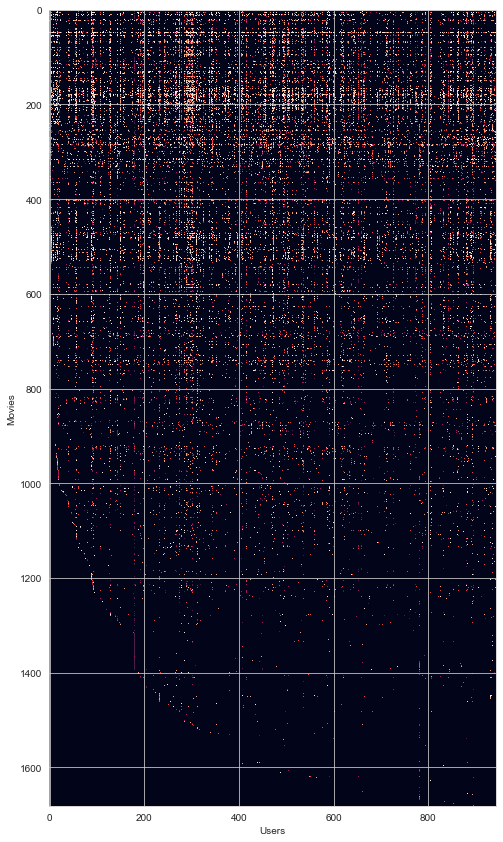

In [9]:
plt.figure(figsize=(8,16))
plt.imshow(Y)
plt.xlabel("Users")
plt.ylabel("Movies");

In [10]:
def cofiCostFunc(params, num_movies, num_users, num_features, y, r, lambda_):
    
    x = params[:num_movies * num_features].reshape(num_movies, num_features)
    theta = params[num_movies * num_features:].reshape(num_users, num_features)
    
    J = 0
    x_grad = np.zeros((x.shape))
    theta_grad = np.zeros((theta.shape))

#     pred = np.dot(x,theta.T)*r               # works the same as the function below

    ######## predicting ############
    
    pred = np.zeros((num_movies,num_users))
    for i, c, in enumerate(x):
        for j,d in enumerate(theta):
            if r[i,j] == 1:
                pred[i,j] = np.dot(c,d.T)       # predicts only when user has rated the movie before
    
    error = pred - y
    
    ########### cost ############

    J = 0.5 * np.sum(error ** 2)                # j = 0.5 sum(error**2, if r[i,j]==1)
    reg_J = J + (lambda_ / 2) * np.sum(x**2) + (lambda_ / 2) * np.sum(theta**2)
    
    ########### gradient ############
    x_grad = np.dot(error, theta) + lambda_ * x                 # nm,nu x nu,n == nm,n ['x']      (error.dot(theta))
    theta_grad = np.dot(error.T, x) + lambda_ * theta           # nu,nm x mn,n == nu,n ['theta']  (error.T.dot(x)) 
 
    grad = np.append(x_grad.flatten(), theta_grad.flatten())
    
    
    return reg_J, grad
    




#  Reduce the data set size so that this runs faster

In [11]:
num_users, num_movies, num_features = 4,5,3

In [12]:

x = X[:num_movies, :num_features]
theta_ = theta[:num_users, :num_features]
y = Y[:num_movies, :num_users]
r = R[:num_movies, :num_users]


In [13]:
print('Cost func with no regularization: {}'
      .format(cofiCostFunc(np.append(x.flatten(),theta_.flatten()), num_movies, num_users, num_features,y,r,0 )[0]))

print('Cost func with Lambda=1.5: {}'
      .format(cofiCostFunc(np.append(x.flatten(),theta_.flatten()), num_movies, num_users, num_features, y, r, 1.5)[0]))

Cost func with no regularization: 22.224603725685675
Cost func with Lambda=1.5: 31.344056244274217


# Importing movie names

In [14]:
with open('movie_ids.txt', 'r') as f:
    x=f.readlines()

In [15]:
movies = []
for i,c in enumerate(x):
    movies.append(x[i].strip('\n'))

# Initialize my ratings

In [16]:
my_ratings = np.zeros((len(movies),1))

In [17]:
# ratings given according to the choice of the user for whom movies are to be recommended

my_ratings[0] = 4 
my_ratings[97] = 2
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63]= 5
my_ratings[65]= 3
my_ratings[68] = 5
my_ratings[82]= 4
my_ratings[225] = 5
my_ratings[354]= 5


In [18]:

for i in range(len(movies)):
    if my_ratings[i]>0:
        print('{}  has been rated {}'.format(' '.join(movies[i].split()[1:]), my_ratings[i][0]))
    
    
    

Toy Story (1995)  has been rated 4.0
Twelve Monkeys (1995)  has been rated 3.0
Usual Suspects, The (1995)  has been rated 5.0
Outbreak (1995)  has been rated 4.0
Shawshank Redemption, The (1994)  has been rated 5.0
While You Were Sleeping (1995)  has been rated 3.0
Forrest Gump (1994)  has been rated 5.0
Much Ado About Nothing (1993)  has been rated 4.0
Silence of the Lambs, The (1991)  has been rated 2.0
Die Hard 2 (1990)  has been rated 5.0
Sphere (1998)  has been rated 5.0


In [19]:
def normalize(y,r):
    
    m,n = y.shape
    
    mean = np.zeros((m,1))
    y_norm = np.zeros((m,n))
    
    for i in range(len(y)):
        mean[i] = np.sum(y[i]) / np.sum(r[i])   # sums y and divides by sum of r (only when rating has been given)

    for i in range(len(y)):
        y_norm[i] = (y[i] - mean[i]) * r[i]     # y - ymean * (r(when rating is not given ynorm returns zero))
        y_norm[i][y_norm[i] ==0] = 0            # for some reason above eqn returns -0, hence converting those to 0

    return mean, y_norm

In [20]:
def gradient_descent(ini_params,num_movies, num_users, num_features,y,r, lambda_, iters_,alpha):
    
    x = ini_params[:num_movies * num_features].reshape(num_movies, num_features)
    theta = ini_params[num_movies * num_features:].reshape(num_users, num_features)
    
    J_history = []
    
    for i in range(iters_):
        
        params = np.append(x.flatten(),theta.flatten())
        J, grad = cofiCostFunc(params,num_movies, num_users,num_features,y,r,lambda_)
    
        x_grad = grad[:num_movies * num_features].reshape(num_movies, num_features)
        theta_grad = grad[num_movies * num_features:].reshape(num_users, num_features)
        
        x = x - (alpha * x_grad)                     # x = x - alpha*x_grad
        theta = theta - (alpha * theta_grad) 
        
        J_history.append(J)
        
    params_final = np.append(x.flatten(), theta.flatten())
    return J_history, params_final

In [21]:
r = np.zeros((nm,1))
for i in range(nm):
    if my_ratings[i]>0:
        r[i]=1
      

In [22]:
Y= np.append(Y,my_ratings,axis=1)
R = np.append(R,r,axis=1 )

In [23]:
nm, nu = Y.shape

In [24]:
# randomly initialize X and theta

X = np.random.randn(nm,n)
theta = np.random.randn(nu,n)

ini_params = np.append(X.flatten(), theta.flatten())



In [25]:
ymean,ynorm = normalize(Y,R)

In [26]:
lam = 10
iter_ = 500
alpha = 0.001

J_history, params_final  = gradient_descent(ini_params, nm,nu,n,ynorm,R, lam,iter_, alpha)

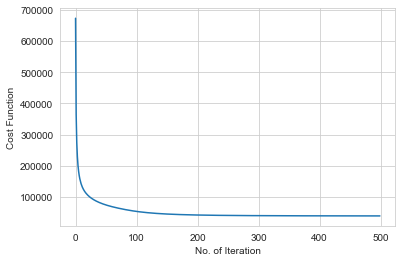

In [27]:
plt.plot(J_history)
plt.xlabel('No. of Iteration')
plt.ylabel('Cost Function');


In [28]:
X = params_final[:nm * n].reshape(nm, n)        # 0 : num_movies * num_features
theta = params_final[nm * n:].reshape(nu, n)    # num_movies * num_features : end == num_users x num_features

In [29]:
myratings = np.dot(X,theta.T)[:,-1].reshape(-1,1) + ymean
# num_movies x 1

# Prediction, include movies rated atleast 50 times

In [31]:
ratings_sum = np.sum(R,axis=1).reshape(-1,1)

idx = []
for i in range(nm):
    if ratings_sum[i] >= 50:
        idx.append(i)
# only include those movies which have been rated more than 50 times

In [32]:
ratings_ = myratings[idx]

movies_ = []
for i in idx:
    movies_.append(movies[i])

In [33]:
movie_ratings = pd.DataFrame(ratings_, np.array(movies_), columns=['ratings'])

In [34]:
print('Movies Recommended to you\n')
print('*************************\n')
for i in movie_ratings.sort_values('ratings', ascending=False)[:15].index:
    print(' '.join(i.split()[1:]))
print()

Movies Recommended to you

*************************

Star Wars (1977)
Shawshank Redemption, The (1994)
Wrong Trousers, The (1993)
Close Shave, A (1995)
Schindler's List (1993)
Usual Suspects, The (1995)
Raiders of the Lost Ark (1981)
Wallace & Gromit: The Best of Aardman Animation (1996)
Empire Strikes Back, The (1980)
Casablanca (1942)
Titanic (1997)
Braveheart (1995)
Return of the Jedi (1983)
Third Man, The (1949)
Rear Window (1954)

